#### SUM main + ExMAS + MSA + KPI


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import math
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from scipy import optimize

import ExMAS.utils
from ExMAS.utils import inData
from src import functions as fncs
import random

# import seaborn as sns

In [2]:
OTP_API = "http://localhost:8080/otp/routers/default/plan"
params = ExMAS.utils.get_config('data/configs/default_SUM.json')

In [3]:
# Load graph
inData = ExMAS.utils.load_G(inData, params, stats=True)

In [4]:
# Read files with data: Krakow zones and their centroids
gdf_zones = gpd.read_file('data/krk.geojson')
gdf_centroid = gpd.read_file('data/krk_centroid.geojson')

<AxesSubplot:>

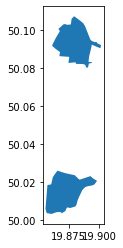

In [5]:
# Read SUM areas: Bronowice and Skotniki
gdf_areas = gpd.read_file('data/sum_areas/sum_areas_B+S.shp')
gdf_areas = gdf_areas.rename(columns={"nazwa": "name"})
# transform coordinate system to EPSG:4326
gdf_areas = gdf_areas.to_crs(4326) 
gdf_areas.plot()

In [6]:
gdf_areas

,name,geometry
0,Bronowice Wielkie,"POLYGON ((19.87805 50.08284, 19.87469 50.08260..."
1,Skotniki,"POLYGON ((19.88842 50.01723, 19.88734 50.01662..."


In [7]:
# Read ODMs and calculate the "probabilities" for destinations
od = pd.read_excel('data/krk_ODM.xlsx', 'AM_peak_PuT', skiprows=[1, 2])
od.rename(columns = {'464 x 464' : 'zone_NO', 'Unnamed: 2': 'sum'}, inplace = True)
od.drop(od.filter(regex="Unname"), axis=1, inplace=True)
od.reset_index(drop=True, inplace=True)
od[0:] = od[:].astype(float)
od['zone_NO'] = od['zone_NO'].astype(int)
# filter OD zone number to match city zones and recalculate sum for origins
od = od.loc[od['zone_NO'].isin(gdf_zones['NO']), ['zone_NO', 'sum'] + gdf_zones['NO'].to_list()]
od['sum'] = od.loc[:, 1:].sum(axis=1)
# calculate destination "probability" for each origin point
od_probs = pd.concat([od['zone_NO'], 
            od.loc[:, 'sum':].astype('float64').divide(od.loc[:, 'sum'].astype('float64'), axis=0)], axis=1)

In [8]:
# Read demographic of the city, clean data
df_demo = pd.read_csv('data/krk_demographic.csv', index_col=0)
df_demo = df_demo.rename(columns={"adr_pelny": "address", "ogolem": "total" })
# assign new coordinates for addresses from outside the city zone
filter = ['STAREGO DĘBU' in i for i in df_demo['address']]
df_demo.loc[filter, 'x'], df_demo.loc[filter, 'y'] = 19.872702, 50.100578
# assign zone number to each address point
df_demo['zone_NO'] = df_demo.apply(lambda row: 
                                   fncs.find_containing_polygon(Point(row['x'], row['y']), gdf_zones), axis=1)
# remove the trips with nan zone
df_demo.dropna(subset='zone_NO', inplace=True, ignore_index=True)

In [9]:
# Chosen hub locations for each area
hubs = {"Bronowice Wielkie": (19.88192, 50.08179), "Skotniki": (19.88948, 50.01844)}

In [ ]:
results = fncs.simulate_MSA(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, 
                     degree=6, N=10, max_iter=30, ASC=2.1, results_period=20)

Average expected times obtained in 30 iterations:
- for area Bronowice Wielkie convergence was reached on iteration 7
- for area Skotniki convergence was reached on iteration 11

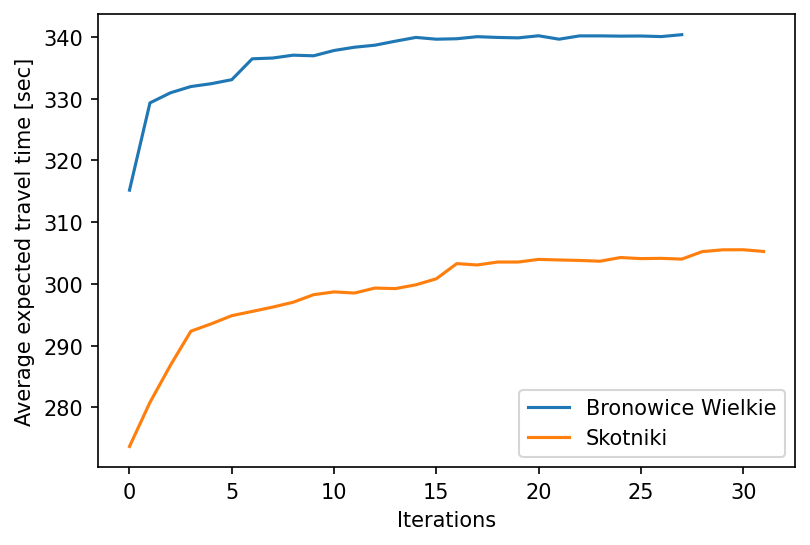

In [57]:
# average t_expexted after applying MSA for 30 iterations
# Bronowice - system converged after 7 iteration, Skotniki - 11
times_b = results['Bronowice Wielkie']['avg_times']
times_s = results['Skotniki']['avg_times']
plt.figure(dpi=150)
plt.plot(times_b, label='Bronowice Wielkie')
plt.plot(times_s, label='Skotniki')
plt.xlabel('Iterations')
plt.ylabel('Average expected travel time [sec]')
plt.legend()
plt.savefig('images/avg_times.png', dpi=300)
plt.show()

KPIs for Bronowice Wielkie area as the result of such simulation parameters:
- N = 10 (number of replications of area demand) 
- max_iter = 30 (number of iterations of sum demand)
- results_period = 20 (iterations after the system stabilized) -> obtain KPIs

(23, 200)


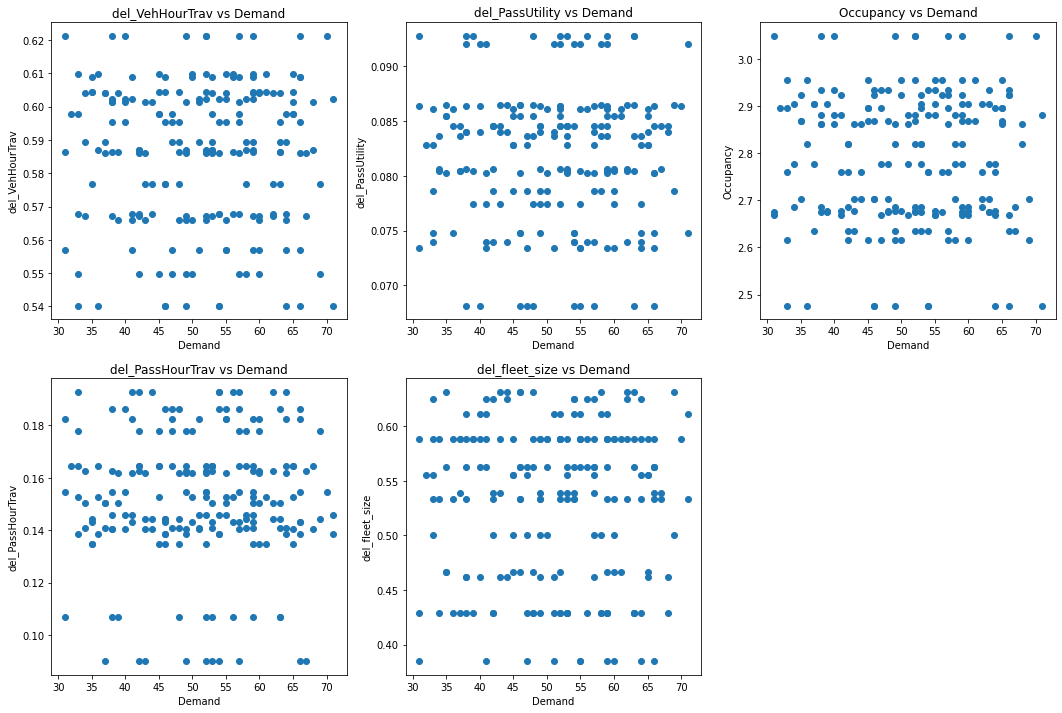

In [24]:
# KPIs - rslts[area]['kpis_res']
kpis_b = results['Bronowice Wielkie']['kpis_res']
print(kpis_b.shape)

kpis_b_t = kpis_b.T
kpis_b_calc = fncs.calc_KPIs(kpis_b_t)

cols_to_plot = ['del_VehHourTrav', 'del_PassUtility', 'Occupancy', 'del_PassHourTrav','del_fleet_size']
demand = kpis_b_calc['nR']
plt.figure(figsize=(18, 12))
for idx, col in enumerate(cols_to_plot, start=1):
    plt.subplot(2, 3, idx)
    plt.scatter(demand, kpis_b_calc[col], label=col)
    plt.title(f"{col} vs Demand")
    plt.xlabel("Demand")
    plt.ylabel(col)
    # plt.legend()
plt.show()

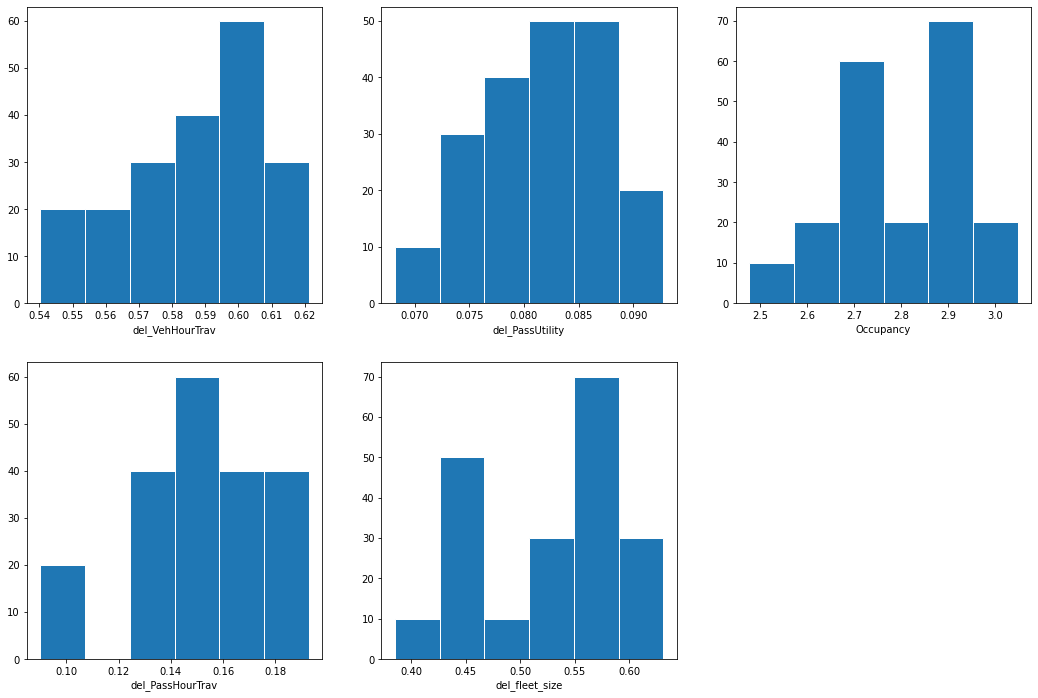

In [ ]:
# KPIs distribution for Bronowice
plt.figure(figsize=(18, 12))
cols_to_plot = ['del_VehHourTrav', 'del_PassUtility', 'Occupancy', 'del_PassHourTrav','del_fleet_size']
for idx, col in enumerate(cols_to_plot, start=1):
    plt.subplot(2, 3, idx)
    plt.hist(kpis_b_calc[col], edgecolor='white', bins=6)
    # plt.title(f"{col}")
    plt.xlabel(col)
    # plt.ylabel(col)
    # plt.legend()
plt.show()

KPIs distribution for two areas

(23, 200)


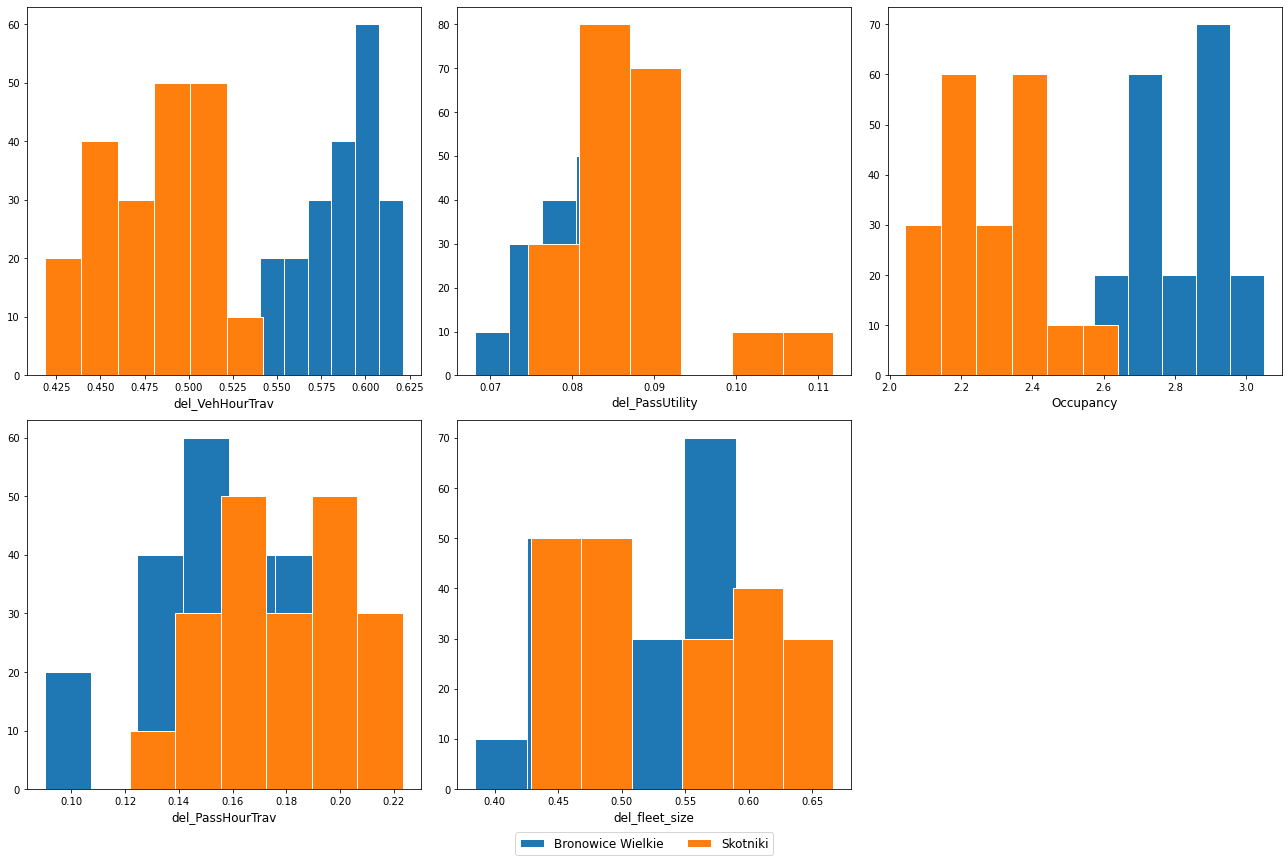

In [ ]:
kpis_s = results['Skotniki']['kpis_res']
print(kpis_s.shape)

kpis_s_t = kpis_s.T
kpis_s_calc = fncs.calc_KPIs(kpis_s_t)

# cols_to_plot = ['del_VehHourTrav', 'del_PassUtility', 'Occupancy', 'del_PassHourTrav','del_fleet_size']
demand = kpis_s_calc['nR']
plt.figure(figsize=(18, 12))

for idx, col in enumerate(cols_to_plot, start=1):
    plt.subplot(2, 3, idx)
    plt.hist(kpis_b_calc[col], edgecolor='white', bins=7)
    plt.hist(kpis_s_calc[col], edgecolor='white', bins=7)
    # plt.title(f"{col}")
    plt.xlabel(col, fontsize=12)
    # plt.ylabel(col)
plt.figlegend(labels=['Bronowice Wielkie', 'Skotniki'], loc='lower center', ncol=2, fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 1])
# plt.savefig('images/kpis_hist.png', dpi=300)
plt.show()

In [ ]:
kpis_b_t = kpis_b_calc.copy()
kpis_s_t = kpis_s_calc.copy()
kpis_b_t['Area']='Bronowice'
kpis_s_t['Area']='Skotniki'
df_b_s = pd.concat([kpis_b_t, kpis_s_t])

df_b_s

,VehHourTrav,VehHourTrav_ns,PassHourTrav,PassHourTrav_ns,PassUtility,PassUtility_ns,mean_lambda,revenue_s,revenue_ns,Fare_Discount,...,fleet_size_shared,lambda_shared,dtype,_typ,del_VehHourTrav,del_PassUtility,Occupancy,del_PassHourTrav,del_fleet_size,Area
0,4675,9260,10552,9260,102.8766,111.243,0.527239,9723.0,13890.0,-0.3,...,4.0,0.527239,{},{},0.567754,0.073978,2.759590,0.192822,0.625000,Bronowice
1,4928,9825,10931,9825,104.4585,118.041,0.553834,10316.25,14737.5,-0.3,...,4.0,0.553834,{},{},0.576795,0.086484,2.703614,0.144183,0.631579,Bronowice
2,4345,8081,9247,8081,90.2439,97.071,0.477058,8485.05,12121.5,-0.3,...,4.0,0.477058,{},{},0.565829,0.077441,2.676153,0.161909,0.588235,Bronowice
3,5186,9907,11434,9907,109.44015,118.9965,0.514921,10402.35,14860.5,-0.3,...,5.0,0.514921,{},{},0.556834,0.073453,2.668159,0.182437,0.384615,Bronowice
4,4117,7973,8891,7973,87.8559,95.7825,0.529917,8371.65,11959.5,-0.3,...,4.0,0.529917,{},{},0.595495,0.068159,2.932988,0.186407,0.562500,Bronowice
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,4616,9456,11015,9456,103.08855,113.5995,0.545013,9928.8,14184.0,-0.3,...,4.0,0.545013,{},{},0.511844,0.092526,2.386265,0.164869,0.600000,Skotniki
16,4408,8929,10737,8929,97.63485,107.2725,0.506759,9375.45,13393.5,-0.3,...,4.0,0.506759,{},{},0.506328,0.089843,2.435799,0.202486,0.600000,Skotniki
17,5027,10980,13279,10980,119.8053,131.907,0.564878,11529.0,16470.0,-0.3,...,4.0,0.564878,{},{},0.542168,0.091744,2.641536,0.209381,0.636364,Skotniki
18,4391,8463,10150,8463,93.1227,101.6655,0.491457,8886.15,12694.5,-0.3,...,4.0,0.491457,{},{},0.481153,0.084029,2.311546,0.199338,0.428571,Skotniki


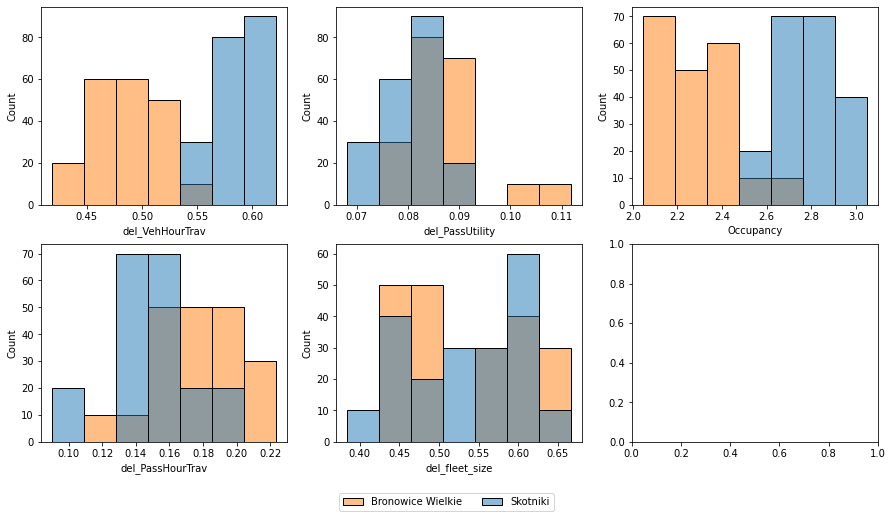

In [93]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

cols = df_b_s.columns[-6:-1]                       

for col, a in zip(cols, ax.flat):
    sns.histplot(data=df_b_s, x=col,  hue='Area', bins=7, ax=a, legend=False)
plt.figlegend(labels=['Bronowice Wielkie', 'Skotniki'], loc='lower center', ncol=2)
plt.savefig('images/kpis_seaborn.png', dpi=300)
plt.show()

In [ ]:
# kpis_b_calc.to_csv("output/kpis_b_1.csv")
# kpis_s_calc.to_csv("output/kpis_s_1.csv")

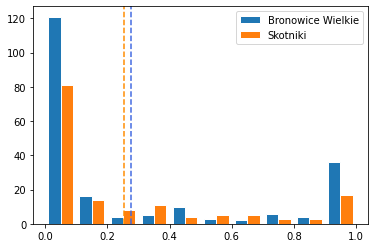

In [ ]:
p_sum_b = results['Bronowice Wielkie']['sum_res'].p_SUM
p_sum_s = results['Skotniki']['sum_res'].p_SUM

plt.hist([p_sum_b, p_sum_s], edgecolor='white', label=['Bronowice Wielkie', 'Skotniki'])
plt.axvline(p_sum_b.mean(), linestyle='--', color="royalblue")
plt.axvline(p_sum_s.mean(), linestyle='--', color="darkorange")
# plt.xlabel('Probability of choosing feeder', fontsize=12)
plt.legend()
# plt.savefig('images/prob_sum_res.png', dpi=300)
plt.show()

Run 100 simulations to calculate primary results:
- N = 100, max_iter = 1, degree = 6

In [ ]:
res_100 = fncs.simulate_MSA(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, 
                     degree=6, N=100, max_iter=1, ASC=2.1, results_period=0)

In [67]:
# results for averages for 100 simulation runs
res_100[0]['Bronowice Wielkie'].to_csv("output/res_100/b_avg_res_100.csv")
res_100[0]['Skotniki'].to_csv("output/res_100/s_avg_res_100.csv")

In [69]:
# results for sum table for the last simulation run
res_100[1]['Bronowice Wielkie'].to_csv("output/res_100/b_sum_100.csv")
res_100[1]['Skotniki'].to_csv("output/res_100/s_sum_100.csv")